<a href="https://colab.research.google.com/github/nikhilnagar503/medical-image-segmentation-lab/blob/main/brain_mri_tumor_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain MRI Tumor Segmentation — Otsu vs Sauvola

## Project Overview
| Item | Detail |
|------|--------|
| **Task** | Segment tumor region in MRI slices |
| **Methods** | Global Otsu vs Sauvola adaptive threshold |
| **Dataset** | Kaggle — Brain MRI Tumor Dataset |
| **Metrics** | Dice Score, Jaccard Index (IoU) |
| **Learning** | Global vs adaptive thresholding behavior |

---

## 1. Install & Import Libraries

In [ ]:
# Install required packages
!pip install kagglehub opencv-python-headless scikit-image matplotlib numpy pandas seaborn tqdm -q

In [ ]:
import os
import glob
import random
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.filters import threshold_sauvola
from tqdm import tqdm

print('All libraries imported!')

All libraries imported!


## 2. Download Dataset

In [ ]:
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


## 3. Explore Dataset Structure

In [ ]:
# Find training folder
train_dir = None
for name in ['Training', 'training']:
    path = os.path.join(dataset_path, name)
    if os.path.isdir(path):
        train_dir = path
        break

if train_dir is None:
    train_dir = dataset_path

print("Training directory:", train_dir)

# Get category folders
categories = ['glioma', 'meningioma', 'pituitary', 'notumor']
tumor_categories = ['glioma', 'meningioma', 'pituitary']

category_paths = {}
for cat in categories:
    for d in os.listdir(train_dir):
        if d.lower() == cat:
            category_paths[cat] = os.path.join(train_dir, d)
            break

# Count images
for cat, path in category_paths.items():
    count = len(glob.glob(os.path.join(path, '*.jpg')))
    print(f"  {cat}: {count} images")

Training directory: /kaggle/input/brain-tumor-mri-dataset/Training
  glioma: 1321 images
  meningioma: 1339 images
  pituitary: 1457 images
  notumor: 1595 images


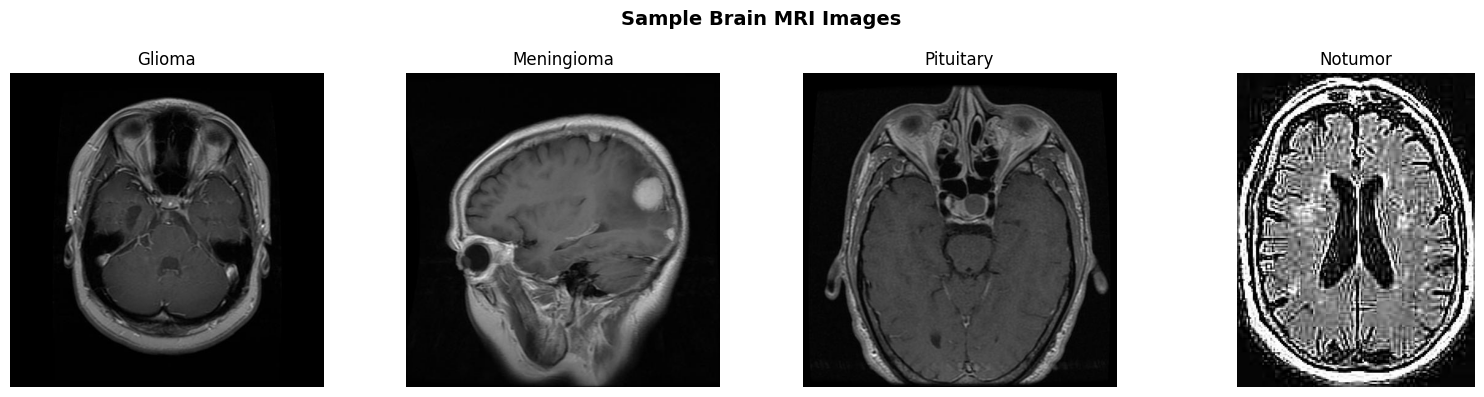

In [ ]:
# Show sample images from each category
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('Sample Brain MRI Images', fontsize=14, fontweight='bold')

for i, cat in enumerate(categories):
    imgs = glob.glob(os.path.join(category_paths[cat], '*.jpg'))
    img = cv2.imread(random.choice(imgs))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(cat.capitalize())
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 4. Preprocessing

Steps:
1. Convert to grayscale
2. Resize to 256×256
3. Apply Gaussian blur (remove noise)


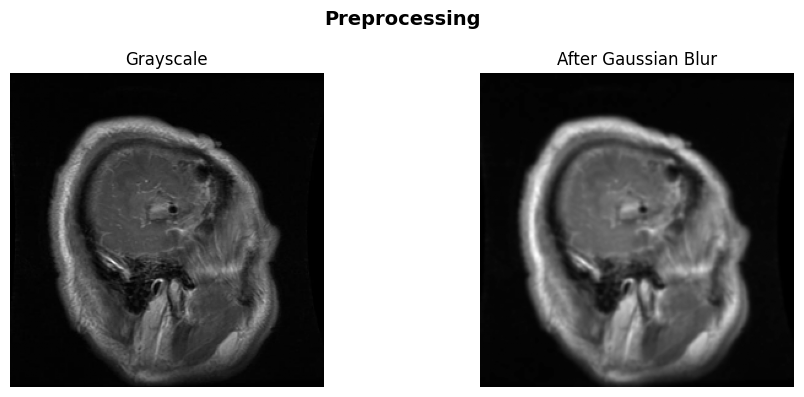

In [ ]:
def preprocess(image_path):
    """Load image, convert to grayscale, resize, blur."""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.resize(gray, (256, 256))
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    return gray, blurred


# Test on a sample image
sample_path = glob.glob(os.path.join(category_paths['glioma'], '*.jpg'))[0]
gray, blurred = preprocess(sample_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(gray, cmap='gray'); axes[0].set_title('Grayscale'); axes[0].axis('off')
axes[1].imshow(blurred, cmap='gray'); axes[1].set_title('After Gaussian Blur'); axes[1].axis('off')
plt.suptitle('Preprocessing', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Segmentation Methods

**Otsu (Global):** Finds one single threshold for the entire image using histogram.

**Sauvola (Adaptive):** Calculates a different threshold for each local window — better for uneven brightness.


In [ ]:
def apply_otsu(image):
    """Otsu's global thresholding."""
    thresh_val, mask = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Clean up small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask, thresh_val


def apply_sauvola(image, window_size=25):
    """Sauvola's adaptive thresholding."""
    thresh_map = threshold_sauvola(image, window_size=window_size, k=0.2)
    mask = (image > thresh_map).astype(np.uint8) * 255

    # Clean up small noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask


# Test on sample
otsu_mask, otsu_thresh = apply_otsu(blurred)
sauvola_mask = apply_sauvola(blurred)

print(f"Otsu threshold: {otsu_thresh:.0f}")


Otsu threshold: 42


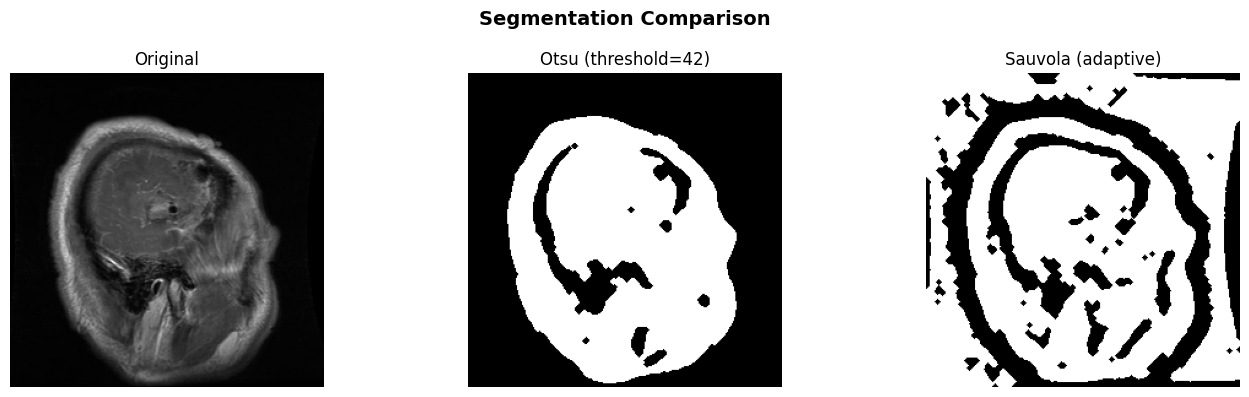

In [ ]:
# Visualize: Original vs Otsu vs Sauvola
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(otsu_mask, cmap='gray')
axes[1].set_title(f'Otsu (threshold={otsu_thresh:.0f})')
axes[1].axis('off')

axes[2].imshow(sauvola_mask, cmap='gray')
axes[2].set_title('Sauvola (adaptive)')
axes[2].axis('off')

plt.suptitle('Segmentation Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. Evaluation Metrics

**Dice Score** = 2 × intersection / (A + B)  → measures overlap

**Jaccard Index** = intersection / union  → also called IoU

Since this dataset doesn't have pixel-level ground truth masks, we create a simple **pseudo ground truth** by finding the brightest regions in the brain (likely tumor areas).


In [ ]:
def dice_score(mask1, mask2):
    """Dice = 2 * intersection / (A + B)"""
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    total = (mask1 > 0).sum() + (mask2 > 0).sum()
    if total == 0:
        return 1.0
    return (2.0 * intersection) / total


def jaccard_index(mask1, mask2):
    """Jaccard = intersection / union"""
    intersection = np.logical_and(mask1 > 0, mask2 > 0).sum()
    union = np.logical_or(mask1 > 0, mask2 > 0).sum()
    if union == 0:
        return 1.0
    return intersection / union




# Quick test

print(f"Consistency → Dice: {dice_score(otsu_mask, sauvola_mask):.4f}, "f"Jaccard: {jaccard_index(otsu_mask, sauvola_mask):.4f}")

Consistency → Dice: 0.6817, Jaccard: 0.5171


In [ ]:
results = []

for cat in tumor_categories:
    img_files = glob.glob(os.path.join(category_paths[cat], '*.jpg'))
    print(f"Processing {cat} ({len(img_files)} images)...")

    for img_path in tqdm(img_files, desc=cat):
        gray, blurred = preprocess(img_path)

        otsu_mask, _ = apply_otsu(blurred)
        sauvola_mask = apply_sauvola(blurred)

        results.append({
            'category': cat,
            'consistency_dice': dice_score(otsu_mask, sauvola_mask),
            'consistency_jaccard': jaccard_index(otsu_mask, sauvola_mask),
        })

df = pd.DataFrame(results)

print(f"\nTotal images processed: {len(df)}")
df.head()


Processing glioma (1321 images)...


glioma: 100%|██████████| 1321/1321 [00:16<00:00, 78.16it/s]


Processing meningioma (1339 images)...


meningioma: 100%|██████████| 1339/1339 [00:15<00:00, 85.79it/s]


Processing pituitary (1457 images)...


pituitary: 100%|██████████| 1457/1457 [00:19<00:00, 75.37it/s]


Total images processed: 4117


,category,consistency_dice,consistency_jaccard
0,glioma,0.681718,0.517126
1,glioma,0.756904,0.608887
2,glioma,0.753796,0.604874
3,glioma,0.690559,0.527369
4,glioma,0.810009,0.680684


In [ ]:
# Overall scores
print("OVERALL CONSISTENCY RESULTS")
print("=" * 50)
print(f"Dice (Otsu vs Sauvola): {df['consistency_dice'].mean():.4f}")
print(f"Jaccard (Otsu vs Sauvola): {df['consistency_jaccard'].mean():.4f}")

print("\nPER CATEGORY")
print("=" * 50)

for cat in tumor_categories:
    c = df[df['category'] == cat]
    print(f"\n{cat.upper()} ({len(c)} images):")
    print(f"  Dice: {c['consistency_dice'].mean():.4f}")
    print(f"  Jaccard: {c['consistency_jaccard'].mean():.4f}")


OVERALL CONSISTENCY RESULTS
Dice (Otsu vs Sauvola): 0.7644
Jaccard (Otsu vs Sauvola): 0.6269

PER CATEGORY

GLIOMA (1321 images):
  Dice: 0.7501
  Jaccard: 0.6063

MENINGIOMA (1339 images):
  Dice: 0.7149
  Jaccard: 0.5651

PITUITARY (1457 images):
  Dice: 0.8229
  Jaccard: 0.7023


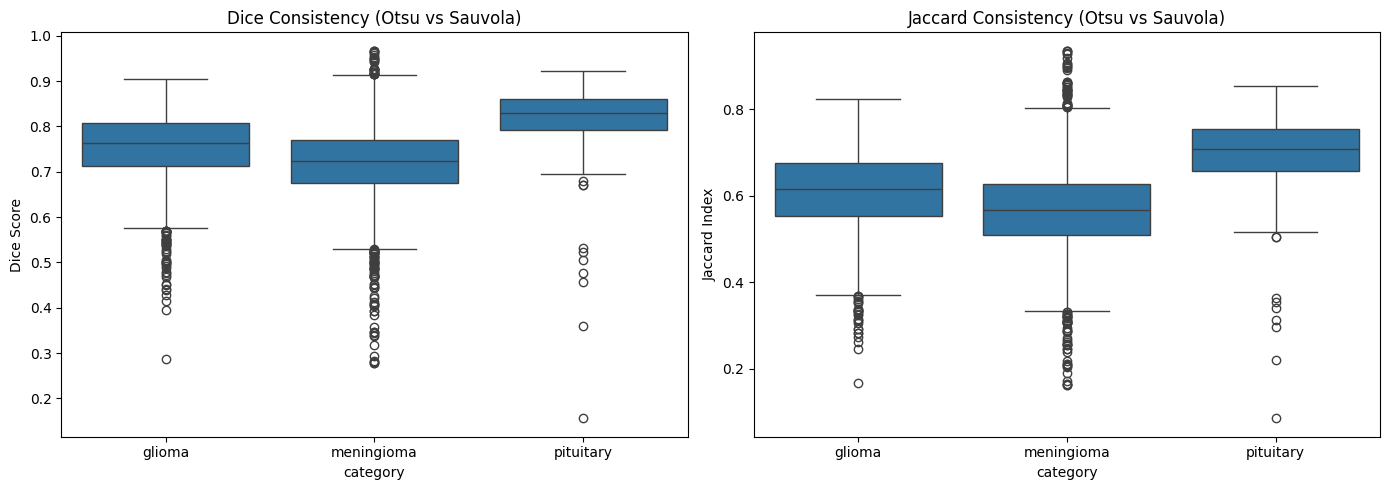

In [ ]:
# Box plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Dice consistency
sns.boxplot(data=df, x='category', y='consistency_dice', ax=axes[0])
axes[0].set_title('Dice Consistency (Otsu vs Sauvola)')
axes[0].set_ylabel('Dice Score')

# Jaccard consistency
sns.boxplot(data=df, x='category', y='consistency_jaccard', ax=axes[1])
axes[1].set_title('Jaccard Consistency (Otsu vs Sauvola)')
axes[1].set_ylabel('Jaccard Index')

plt.tight_layout()
plt.savefig('consistency_boxplot.png', dpi=150)
plt.show()


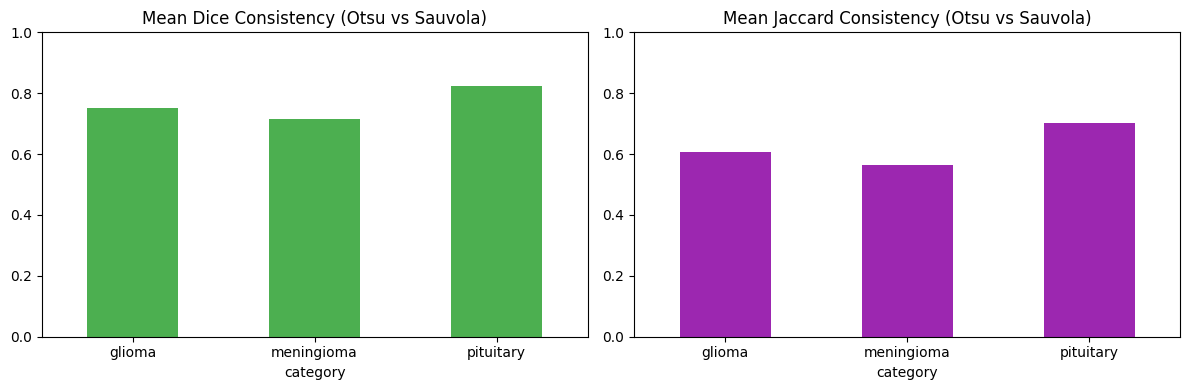

In [ ]:
# Bar chart — mean consistency scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Mean Dice consistency
means_dice = df.groupby('category')['consistency_dice'].mean()
means_dice.plot(kind='bar', ax=axes[0], color='#4CAF50')
axes[0].set_title('Mean Dice Consistency (Otsu vs Sauvola)')
axes[0].set_ylim(0, 1)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Mean Jaccard consistency
means_jaccard = df.groupby('category')['consistency_jaccard'].mean()
means_jaccard.plot(kind='bar', ax=axes[1], color='#9C27B0')
axes[1].set_title('Mean Jaccard Consistency (Otsu vs Sauvola)')
axes[1].set_ylim(0, 1)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('consistency_barplot.png', dpi=150)
plt.show()


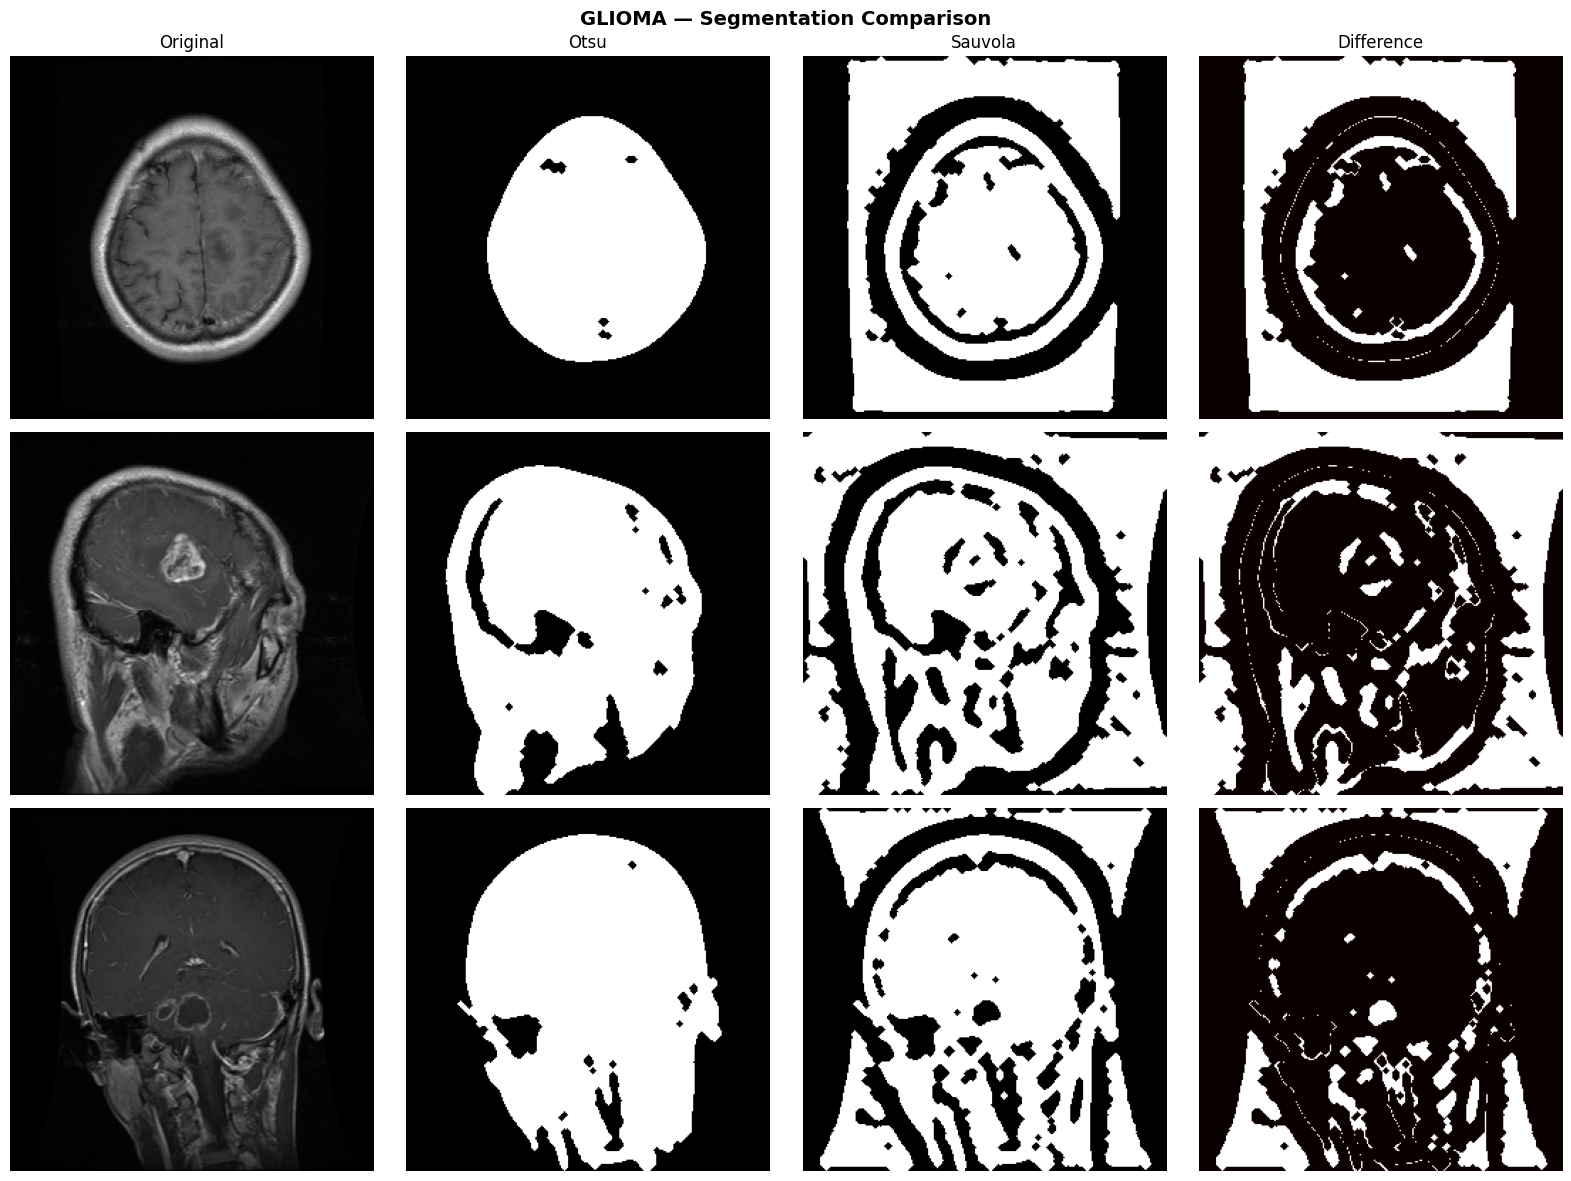

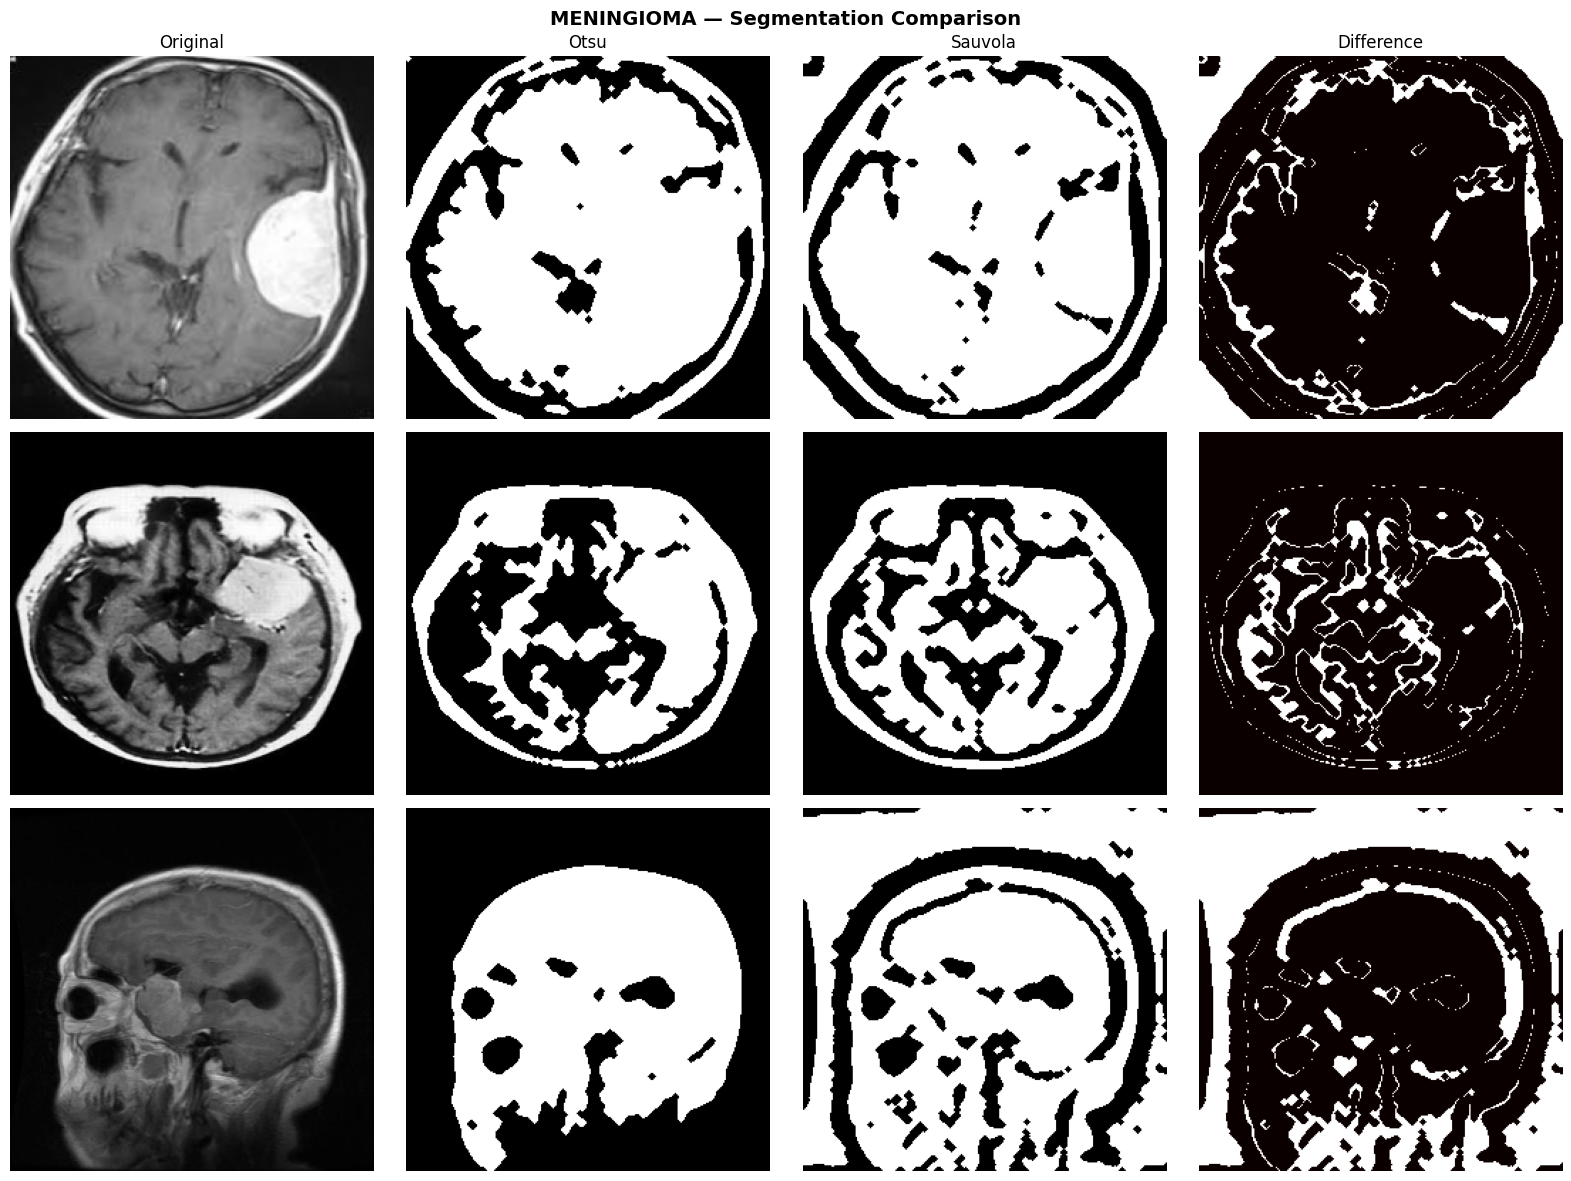

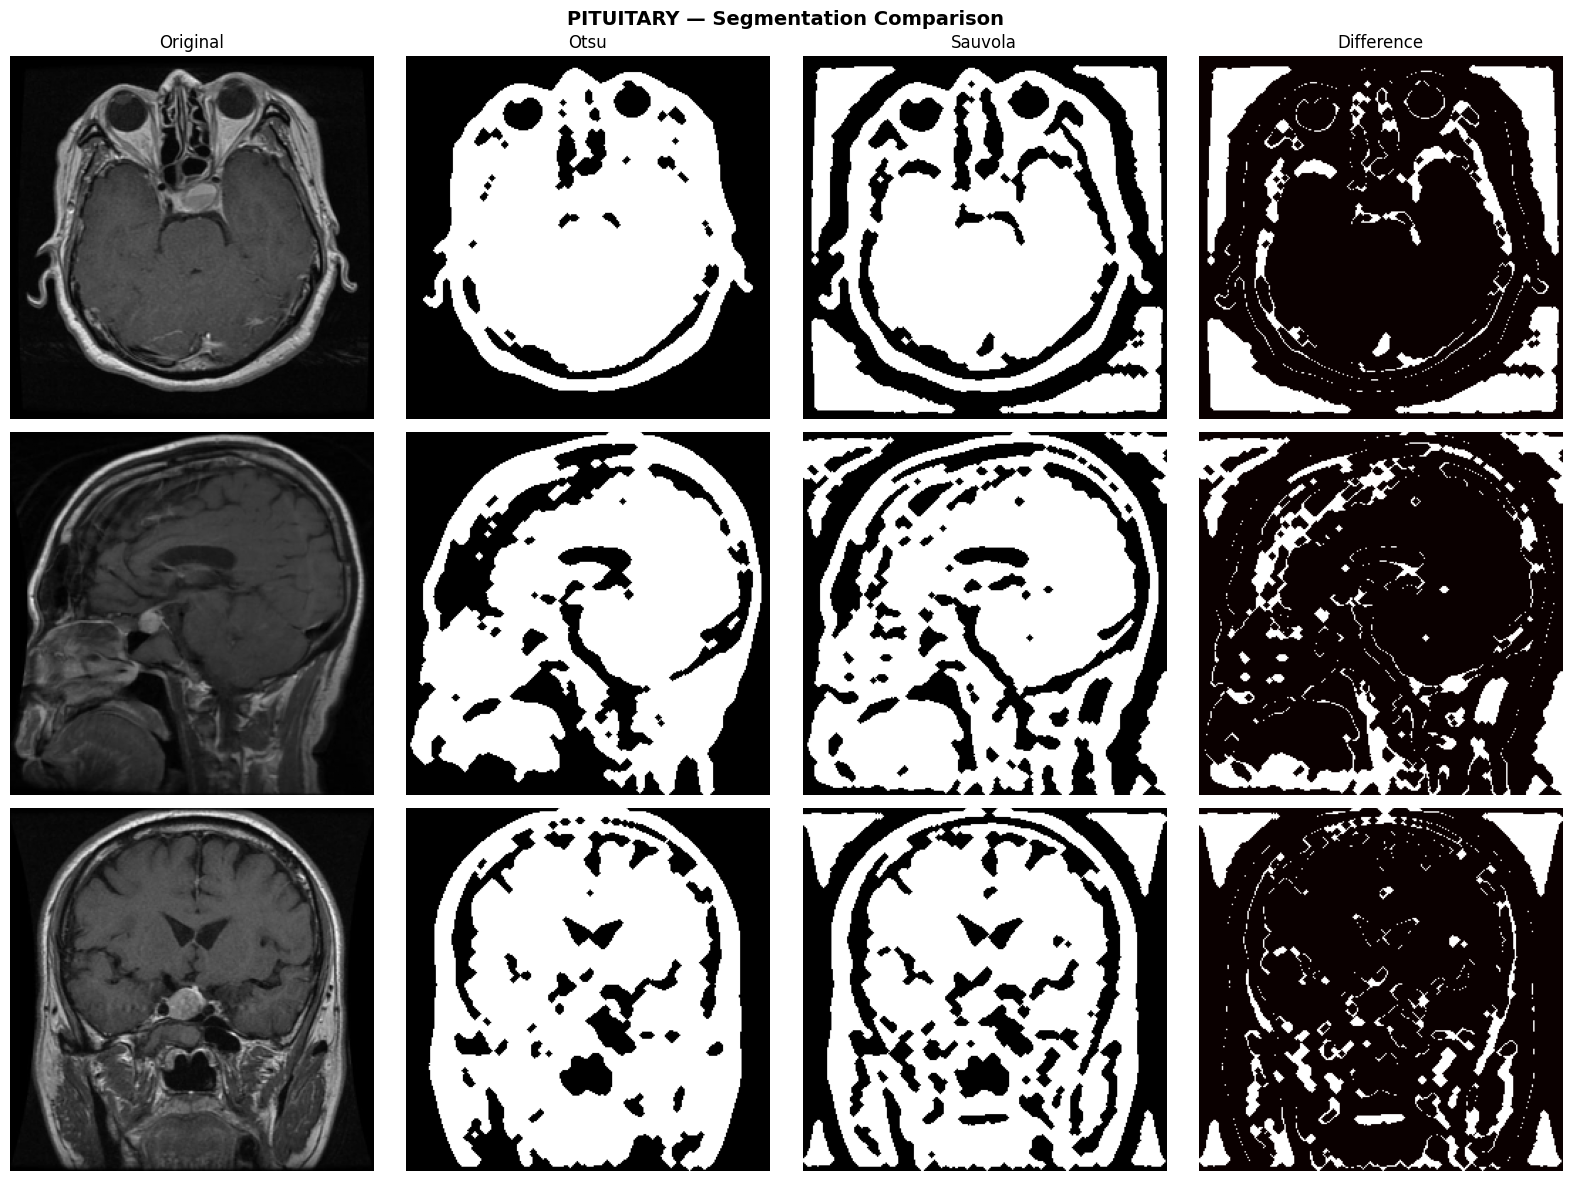

In [ ]:
# Show Original | Otsu | Sauvola | Difference for sample images
for cat in tumor_categories:
    imgs = glob.glob(os.path.join(category_paths[cat], '*.jpg'))
    samples = random.sample(imgs, 3)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle(f'{cat.upper()} — Segmentation Comparison',
                 fontsize=14, fontweight='bold')

    axes[0, 0].set_title('Original')
    axes[0, 1].set_title('Otsu')
    axes[0, 2].set_title('Sauvola')
    axes[0, 3].set_title('Difference')

    for i, path in enumerate(samples):
        gray, blurred = preprocess(path)

        otsu, _ = apply_otsu(blurred)
        sauvola = apply_sauvola(blurred)

        # Consistency Dice
        d_cons = dice_score(otsu, sauvola)

        # Difference mask (where they disagree)
        diff = np.logical_xor(otsu > 0, sauvola > 0)

        axes[i, 0].imshow(gray, cmap='gray'); axes[i, 0].axis('off')
        axes[i, 1].imshow(otsu, cmap='gray'); axes[i, 1].axis('off')
        axes[i, 2].imshow(sauvola, cmap='gray'); axes[i, 2].axis('off')
        axes[i, 3].imshow(diff, cmap='hot'); axes[i, 3].axis('off')

        axes[i, 2].set_xlabel(f'Dice Consistency = {d_cons:.3f}')

    plt.tight_layout()
    plt.show()


In [ ]:
# Summary table
rows = []

for cat in tumor_categories:
    c = df[df['category'] == cat]
    rows.append({
        'Category': cat.capitalize(),
        'Images': len(c),
        'Mean Dice (Otsu vs Sauvola)': f"{c['consistency_dice'].mean():.4f}",
        'Mean Jaccard (Otsu vs Sauvola)': f"{c['consistency_jaccard'].mean():.4f}",
    })

# Overall
rows.append({
    'Category': 'OVERALL',
    'Images': len(df),
    'Mean Dice (Otsu vs Sauvola)': f"{df['consistency_dice'].mean():.4f}",
    'Mean Jaccard (Otsu vs Sauvola)': f"{df['consistency_jaccard'].mean():.4f}",
})

summary = pd.DataFrame(rows)
print(summary.to_string(index=False))

# Save detailed results
df.to_csv('segmentation_consistency_results.csv', index=False)
print("\nResults saved to segmentation_consistency_results.csv")


  Category  Images Mean Dice (Otsu vs Sauvola) Mean Jaccard (Otsu vs Sauvola)
    Glioma    1321                      0.7501                         0.6063
Meningioma    1339                      0.7149                         0.5651
 Pituitary    1457                      0.8229                         0.7023
   OVERALL    4117                      0.7644                         0.6269

Results saved to segmentation_consistency_results.csv


# Conclusion

Based on the consistency results between Otsu and Sauvola thresholding methods, we can observe that both approaches produce relatively similar segmentation outputs across the dataset.

## Overall Performance

- Mean Dice Consistency: 0.7644  
- Mean Jaccard Consistency: 0.6269  

The overall Dice score (~0.76) shows strong agreement between global (Otsu) and adaptive (Sauvola) thresholding methods. This means that in most MRI images, both methods segment similar regions.

## Category-wise Observations

- **Glioma**
  - Dice: 0.7501
  - Jaccard: 0.6063

- **Meningioma**
  - Dice: 0.7149
  - Jaccard: 0.5651

- **Pituitary**
  - Dice: 0.8229
  - Jaccard: 0.7023

Among all categories, Pituitary tumors show the highest consistency between the two methods. This suggests that pituitary tumors may have clearer intensity contrast, making both global and adaptive thresholding behave similarly.

Meningioma shows the lowest consistency, which indicates that adaptive thresholding reacts differently to local intensity variations in these images.

## Final Interpretation

The results suggest that:

- Otsu and Sauvola are generally consistent for brain MRI tumor region detection.
- Tumor type affects segmentation behavior.
- Clear and well-defined tumor structures result in higher agreement.
- More complex or diffuse structures reduce agreement.

Since no ground truth masks were available, this study measures consistency between methods rather than true segmentation accuracy.

Overall, classical thresholding methods show reasonable agreement, but more advanced segmentation techniques may be required for precise medical analysis.

